In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
from talus_data_analysis.load import _read_object_from_s3
from talus_data_analysis.elib import Elib
import pandas as pd
from dotenv import load_dotenv
import gzip
import zlib
import base64
import binascii
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from pyteomics.auxiliary import BinaryDataArrayTransformer

In [4]:
load_dotenv()

True

In [5]:
ENCYCLOPEDIA_BUCKET="talus-data-pipeline-encyclopedia-bucket"
MZML_BUCKET="talus-data-pipeline-mzml-bucket"

In [6]:
elib_file = "wide/210308_MLLtx/RESULTS-quant.elib"

In [ ]:
elib_conn = Elib(bucket=ENCYCLOPEDIA_BUCKET, key=elib_file)

In [ ]:
df_entries = elib_conn.execute_sql(sql="SELECT * FROM entries", use_pandas=True)

In [ ]:
df_entries.head()

In [ ]:
intensity = df_entries["IntensityArray"].values[0]
intensity

In [ ]:
dintensity = decode_byte_array(intensity, format_characters='f')

In [ ]:
dintensity

In [7]:
test_intensity = "eJwlV3k81N0XHomISpb0WkJlr2whUc5kryTirWTNW+mNFvUW5X2NSJIWlSXZkiWRfc8yZoyxjmXs+y4kW/1oM7/m+Ot+vvd777n3POc5zzkXNj1s3+bWCgQCQdrrLxp8FBn1cxfqghUWi6V5Lheuv6nkTz4+BFd2v9p5tLqIvW5Q+lIlWFQ2VtBCK+H3Mqm1TAp79KnemQdFN529zYMr4DqP+iPPdCpsOBWe8IwaBpLfTf+uGy2CHyzWwP1X+TBf6qyTNNINuvJ+VsLDD9l2yRv5mFCq5MLXE1XK/gZDvkoYc5fo5rdYS1TZSpY4X9AOd23ftq9ZbAIzgzs8S5l+sP/c8BZ5vSnYeTdXWWYnFWZXmgQsA3tB0PuW7GRXJdsPqZvBdMh6vfsXcVMnzFNP3n9jUgPvTDMNozdIEBlcJiTOWQKR7f9YaAvbD/3eOxSwmfNfX5mYi/5eX6oG5fKOd2Fibfif60Q++hvjWMv+T3qx9iOO5iYMWBttb3s4fxI2a3l+XbM3DT4/n/35wLEHKEuECLnIbFCNiOk8sf8N+16OFsKF6HfEmg7Ecb6Pwp4vX9L+wP6OfTqbA2f6+LIFypjw6/e8XmchNCu9M72rXgsudl6Civ/VgGXjpakQvVjo8C7pnr3RhP6aWlXAhXvXlNbyrmf75aRD7IFimYZQBYVZ6LqhpqdCjmbbYwW+LIcoDSVd7tzVe/BydUGY1dWkJxotsKG3kMfNuA9OaTWPr7tJBQOjbJbxujn0u8aFjPE5yD8Nl0O+/Tlf+hi2F2b+xSn3DPG6fGcQPFXtHy/P18Jes7kBQkoSlF7dMX32aykIWhCNtza0sNc5LW0jw6enWZq9CWhv8CZfG1iZ1XK9tH+K38zpauh8fDp25kcK8GYlF+j8UQIBiyFW7+vbwNyTdvREzijizvrcAhyes6aCMaOgECRTXufcw/ZPX5mrgX1flpB5HmiQbHxVzavhZGSUzo0Hk8BhrPusYqgGIO2PQULgJOKvuZDP3jfQOpIHXiJqUWEL2ZBw2W3etScarIrkQoTOvMV7MQ50YH7MHi+Dh1teS5nrCxDVbc9qtcuOsP/H2ZPrgdPda9/xHe/AtzEn8Y1uP3ue8GOcDG+rQ0SVlZZBbqMWz/uLo+D7TcaV8iMT70kMLICnhLfnXU2YsIPSO6f/hUDkNovfvjmvD/47cmHa7n/jcNhm4FmmVjPsMuf/Zk5KgM/Zh3n2Lydi/MIaGPD2xA8vZ/V6qPtZaHlhggmJuUGNOqm58N5N/EHAUDfyi6hSAkneJ8W+BTej3+RDpcjrY9wV7LHcX7QFtrEyec3f0uC1j5y5rfIveCOQ8tFZdxE+f6znMlrTA/bJ/wYsi0yD/ElnRUHLHuSdiE0RvMzkoO1IToA6v1g1rW9xwL9wkaIomgHU0D2+Y1FViBtndS3oWhvQR6RbMQ9emRSDlavx5vSqd2z8Yz0kitjz+hZVObCYa6ZZ7jQLhcYPZuzfDUG/gsMjxt5YeGETE+9t5o/2LLnLQf7LQa/6lQ7ooc+1f9lMRT+tZRsQF7/4ZpBeCQ0/sbcKeXfq8BTu21VchueX6hVDf6ugZue3CXA7tLAxm7MGMn61mSoaMJHnhT+bkWdcZQwIkmhwMpeoBuex45zcMUng8u7Grq1x1bAjKEOV41o95kdabjniyrubChy/dcVWoRca6JZRFu9zYHqAJ96k5jUQtwoZcjguou4WfW9aHW3XYL7uDcB5Qt9SN953jVYNcOnb+NNyBiHw/pZesmsE3mv8nyrUCS/7Jtjbqu12M42T2PhQ8o7PJmniqXQZwwUTDiKbzxUyqCsDX8poyN9XZ6rhG3xTua4cgHGPIYxC5EfBllOqOdBMkR82GKsDC6vxG1tPV0CUwv6NLIsK+Iu4xmpTQDb6tT6RAv2HONx5Umqh7Rih09Swnz3v6DJQBWOn7h5TS8mGoo4wdYOCWLT/9jUFmvQLswvqkmG4+I6s7nHk2cAlHzLcDVVz8O0js+/nQ3OsgktnHvgl1sRDxv6vC7ty6Yi7/90a5JfPRCkEkYLf92QPQaS0WJTKWDNQx99EcZ8uwvOZRhVgJ2l56bbee7AzMA0TF5/CvPrjIB3z2smSgbhlKbeBg7yOsrZxHvgukpPu3a+FaHPB/N7wQbyvp2IJ2Gc2/PoQ+4a9T0o0rBj1xP9KKXj5EaPCHTIwXlUOzWB3ZShNViEN7h+VrtywMRtqiDkexj/x3IEaHSbyIVOKin5EumJ9Gbifi/VS/xGhDfqOqHs8ycwEuUXt/+l51cKFo/tk9de2wn1XJu2AYBxY/ityZYtOEigZPCk/mpgNN+wKoi8KMSD92WRZlWUt6NkctxPPa4PZUmnPRM5c5POiRCPEWWswNK5mQefDA9w6ol0wcXjdUdK1cOByZhnpN2bBxAT/kw4F5IVj79kKCFPk5Oee7AJGsZDcJL0ZxJmnm0vVfBGvyy+RZ/qv5WggU8pv2LiZDnwaHDn0cyFQr15Qm+3WA4ZU9y3f9Xpgd/pQvSrfav2KE6OAZarZ5ut1dSCd5O6gElGB9gwmy8D+j57DS9ZM0AlI2ymuMgJHS6ZXcj8nw3YNpe1a4qWoA9SRMgiZMbkUfr4OymTpHv2HisD67Bfrri2FoDlit3+Quxbz+EshHfVijwrmu7S1FfLLR7IRcXa8sacS54W7K8Ahc0qh3bAC14t2loK15LOxBBF+Iqcn6+lKcirIngh91MwzAyuNV8m3tCmoH763m+FMe+Lpy0EvgRIKXRu5MmCMIVnOF1gLB0Ufk9I8qbBeQEN49NYQLBYLtoZXIl5SoUUUuJco2vr0LOaHvv1MGegIXmcKbE+HKuLZlylZH8DXOmJZUbUEcXnVO4D5ee8c1jVpbvcJaDkhtJzKPQpy8tOkHZ7xkNKw7dzawstg3RS/rO0bAS+ITTnMi1QIXRKffJC/2pd4uKzm1+1AMsbhyu4atg4N9q78Ql1xt10Cav/xjrypBFCkRXq3zM4A43ZwlfdvvRzneqIa0zKBdaDjAB10Sq9/P2mUBM/jT8W423Wy4+IjX9+I/YgXGeu2tG1rEwQy5pyHGO/Rz4TeDxDur566cr4EtH9mGF2wZIJiwHlqkxPqupQwtRz35d2vQb8/MTqg69D8R4+4txgvcWEyBMc/alXbUwC3/cWSC1x6YMRrVvihxAesr4u2Q1Au3logRG8A/kKv/JC+brA5OSvWeaYP/abqtoLc4bXp+yZoyKPCH11wkdvmuNnCGJg8D7BsSptEnJ/F90ClxKdTFyk1IFGwz8JbbAQ6SmaP9P6agzvh5+sDBwZQPwqlh/Dcc3yTeP/+fOoqn1pa4FA//8rc7/r++xxH3b97EP9aJcTdZ0kK6z7ZZQbz3jEkoQ3xtwkchJMbFo3Lya1QLyxV+188FeM0JdgPD/KNJC5rDcJwoTGHPyfWS6mCaAbc1H9T6FOfD8G04K/xmp/gVeTXI6PDC2CTodzOMbaPXTcIaocmMJ9L/CSJti4KNeHF0zDwwSfjnMYYdIlMifC2zcFI5p5I3T5dXK9n1IXxekxGf5xOX9lPJLjpbLiRMAxWA//IBv6uIyGGkX+L2I3Atc6TQQ77fgCzLvJRddUY4qFkOgd/yV96Yb1tDOb3nNne6LOeyOZ9LN9G9jgg+R3rbdy7Lz8gYNfC9KYTS6AgwjVKTp4AAYF/vK3Gp0H7yZD3vrvjiN/DOipciOIi/LPSDV/Tnyc02zKgOOaeoorjIDh7OktfmWPCOcpZs0+nsC4S7Aaw35KWiOiCSaqVaodhAVQWynDZV3eAmUXNe4Wkp5iHl9LQv8GzPjSIvhrgr+eP7x342lKNcfLagXrA2hyG+kQW6ZwDTea38Sm3EdSJXUcaQJekUjnP6AYz73UTMWPTGK+AC1VAYim5GtydRzv0622wTTs4tj1g1c4v2jDy5/QZPI90d80EOFk+PkYbLWfnI8lavx1alKNfhgQ+xPqU/7ofhiUThjjWJaL9vCwa7j/iO47xaVJnwmjy19FiiVSovOH4kosvC/H9M3UQ7YtvHsZRXw3jQ87Rxr4FqjsGQGqekTPjj+8Mx7GX/cC7tF/66bQwmweQzdsO/hv+7TMM+o7/87mawdRjTPX7h06081ETdSPO9+MifOkh71KizMBeupbOk/lMnF/eXgUCPPIOYhYJIEJ9/oPUEo94u/m2IB8jROpRL2yOI96s17Oojz71j5tARJ37fYx9CVzJi9nUsKsZ0nY+XUiuRLzi9C60gy3/kc/U26vxelaAOj6oQ17tm/xpq31Sox++3wZtL6J+SrvOY76SGoywfyCIrRuEkgYFekJnL34X1m5krycdesvNHuOEtyzjeX4pXbj/y2XMV1Yk9yzOK4YPwx4eoO4RXYZbTrRRozhOdl/F+lzUCIf+k54dUR6HQA9Vb7v5CVi/MZUYF9sL5ZkeB7bSVuPjzjUGHspvBNbrHiA+MXkQtsfNiJjFSgpu8dxJPHJpX4pE0yLy1MmpFfORf7wKMkKLP1291gty32wE72swUI8LDyIfHP+8Vw9tnxJee55f7UO8vKcQl+uxqzyR6WyHD6cZ7uK8HRg/16lK1O3E59ifOjoJYV0bZKgPAcmQmK63vBoPlj/zdz/ibrSe2graJO08tfNDeC4lng6xw7f/pyzbBpzbx0Q4bqVhXEmRPQCWrbm/POjQLnPOWpIUB/4xn+xYminYf/vXiBIjXWr4RF+pERmRudPTa4SI03aki0G38R1Z7nGgAkYmd7R2NxUg/yNba3D+RSodpMJK+h2u4PvaSfXvJjg2zpv8ryzmk6N/HRmqD3oE702NwjjFnaDANu9b4ekRRSBvL7YvoL0Chuq4g/QUuoFuIDMMVav9gc+1RlwfTUZe6hualGPf+TluAPO/VL4RvwmT+H5gPTLCPl7fIW61DxAfxner9PzecfR/5iDyWZ9OKYL/A9S+q6M="

In [8]:
trans = BinaryDataArrayTransformer()

In [10]:
arr = trans.decode_data_array(source=test_intensity, compression_type="zlib compression")

In [35]:
arr[:10]

array([20912.48184468, 10952.94628906, 25677.71117499,  5221.2109375 ,
       35461.22030861,  6600.29743357, 10454.25683594, 10539.54497716,
        9638.03222656,  5412.78320312])

In [31]:
test_intensity2 = "eJwt1n1QFPcdBvAdwJjU1hfO6BSNbg7UBtRJTmsopLA50ETDaAasmag1K0e1AXIKJxpBcOUA42sCF0YBo+uBCKiYchFHMXbLEWzEoN4ZRGhwh6PWaIoV0HGAaDPPw1+feb5vvwX+QRAEISPgQ+kXxHNGqPYHQ70khPWjZigttkAlJo9zSys4V+hjjvNLhmoA1JtehsoDI+tTQ6CWbIHCwSQoRdk5tyePNjuh+EUj91piU7B3Owmqv/0GivaAVNxpNdK+YChWmKHcEgOVloVQW2yhM+ycy8hn3nsMqteaWB/no/kBH2G/PBbK6RYonfJBsacHCgkBVvSTR0Hpu1io9S+EQrYF6iuSmNupOvQX+lMuVD6soHMqORdygXdnjtqAfXcSFNbbobQ8j15pos4eqFUGboS/M0BhuRGq84OZZ5uhFJfIvMfJ7Ofh3PvdUGn0S8O7LSaoxs+Dwp9joOL5DGrFRVCa4WC9U4Vi05d0cR3r31P1H41QPuhhfaqXTu/jnYmB6ZirSqMPCqG+vQiKYx3MT7+EWriL9Z81zj+6BoVcD+sVXtaL/Wyo/zsQSoNGqC02sb7JDPVt8VCZm06bR7yUy7m2Qs5V1XE/2sX6O256yrAJ7/lNgUqkEWoPqaKFst9sYnZH0KIEKJ5Ip9E2KCyzM2938I7khPrJGjrHBaXrHt6d4JeBetsEKD9vYB4fArXjJij44qH630SoFBg24858I1SsZii/GQvVuOVQey2F/TdsrIfboWht5P5AN/PX/lswv9kAxUXBzM1hUD1pgtK6eVD/mop9ZtZ/jGe226Gw28H62nLWw1xQnuzmvQ4P3RH2Mb6vcB5UIyxQfjcd6u1F9EwZlC47oTjVBbWdXtYfBG3Fu7kWqOxKgVKJHeqbHMyJ5VAbrGPd+hXrbzZB1eqF8t5Oztl9rF++D8Wy/9HT/fTcEN89ImRivsKf7hufye+eAmVpHutpSVDpT2H9mY11/21Q/cDO/pw8KGx3sG84xHu3yqH4nxNUd9F6L+d33uDcpFu8c6wHSif6WZ8akIV3pk+EknE2FCbPh9r3r0N5OJL9f8XQye9DsT2R+YMkqF9KYXY72O8q4373Ed69Wc4cfY75i4ucc7Zyf/g2s2GA74cHbMP3PTcRiteCae8sKB2YR4/FQG2RlX23DQr1W6BSkkUP2qFc4GDfVc77V//O/lM3HX2D/cft7C/q4t3Bu3yntJ/vXh2TjXs/GKDUHAyVb2bR+jAorI+igzFQbU3I5neu4n7SGs5XWzh3Jol2refdJ3+F+nEr8xUb888fU7+9UEt18N71cr6zoJp1Zy31ubivn2V/60Xut7np7G/5bvAV5q2tzLe9/L5pt7ind47c8bE+eJ/vOvv5c2UNsX7aPwd3Sg1Qyp0GlYZIeuotmh3HuYIEqA2ugsIPFtaL1zMLqVD9kcqNm9g/lsX+P7fxnSoHrSyHYmcF87njzKdP8J2LLjrQwH6fm3dib/Dupz5+n6WXufkB9939nLv7hDksZDvmVrwCpUNzoRAxH6otr0OxI5L5ZjTU7sZwbqmV/aM23hmzFeqROZwbnQfl1F3Mv97LfH4/c20h9174nMaV8G5vGfPmw7ynlbO+7gK/09bE/nPf8ruirvDu6lbebfQyv3SL31flowd6uRc1wHzyCe/XPePewAsK7r0YCMUbk6FkMkLh6StQfzQHyr2vMcdGQKU9EmomM+dHL6F/iue9VSs5fz2ROcjKOxPSuT9mM+tCJt8tzuH3PNrB/sFc9mcVsP/qbuax+zm3oIjvvX2A/Wcl/J7CQ8zSEfZNzpH3Ktk31LAfXcs757/id713lk4/T1++yH5lM3+OZZd4Z9dl9p1XeG96K3MV1V7ycC+0jdl8k99h7mD91S6+/14387o77K+7x3fe6qW/eci51Y/Zj3w68l1+O/B7eHv8Dv49gqjFCOWNoVQyQ2nhEqj9vhQKBZe5H9PKuQwP+6s6eGdZUC76xgiohURB3R4PleREqI5zsl9fw/nIRvY3eqCU38G5+EHWfcNQ2Ga0415uKJQnmJmjV0CxfiWU/rgGqhcToXYmmfNpuZzLKbLzvVIoLDvMuY1OmlDHO2nnmd/w8F5MB/OOLprWzf0NdziffI/3t/Tyu9b2sZ7ymO8nDnIv6SnrxYF52M8IgurWaVA6ZYRyykzm6lD2c+ZCpczEvawIzmVFsW81s782k3u7cll3OuEv/5eO9BuhuPQy+wu76Zle3m3oYz9uiPP5Y/NxTwmEgmMSVFtNUP9uAVQy4qFctgKKjpXcK1vD/Hki1Fanc39tJuePlHK/8jDv1zjZr6nkfkUNc1XtyH4jc2oz98Z5mSd1cj/Ex/rJO3z3wj1m+68K0K9YArX78VCaYYH6nBRmkw2K4VnMa8q411kHlW4PVDs7aEPgTuyHTqFlwTv588/cyd9/KBSum6C8bwnr1clQaquBSn8f87vBn2BuRhaUXrRD7afdUL8fuAvzQ0FQG5UA5fAWqFZ46dFOKH3kG/E+5w9YduN7elKg9tAG1YdZUHxkh8pqF5SsDexvGNqD9zPse9HP3gPFVQNQXjTMfMl/H/9uBqh/kkDPeveNfBdztQ8K7Zb9yI5UetUFRXsDrXVD9XwL1E47PsX74WM/wztdf4Pa8wuKsD/8Byg1+R2W/g+3yL58"

In [32]:
arr2 = trans.decode_data_array(source=test_intensity2, compression_type="zlib compression")

In [36]:
arr2[:10]

array([200.13928223, 201.08509827, 201.12348938, 201.14378357,
       202.08216858, 203.10269165, 204.13323975, 205.13459778,
       207.11155701, 208.07185364])

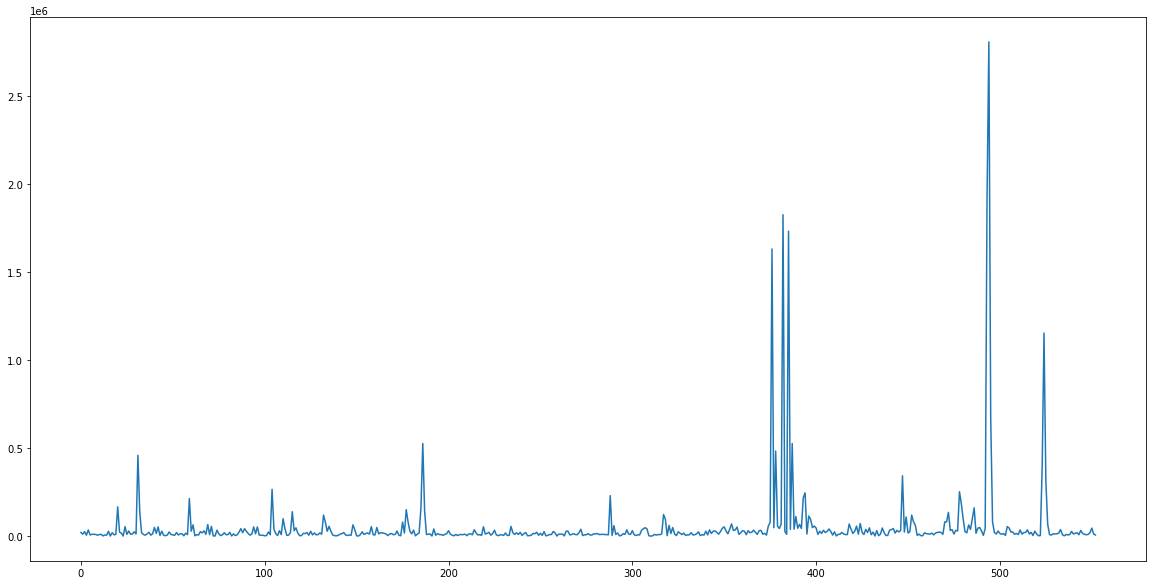

In [28]:
plt.figure(figsize=(20,10))
plt.plot(arr)
plt.show()

In [ ]:
df = elib_conn.execute_sql(sql="SELECT * FROM peptidequants", use_pandas=True)

In [ ]:
df.head()

In [ ]:
total_intensity = df["TotalIntensity"].values[0]

In [ ]:
no_quant_ions = df["NumberOfQuantIons"].values[0]

In [ ]:
intensity = df["QuantIonIntensityArray"].values[0]
intensity

In [ ]:
def decode_byte_array(byte_string, byte_order='!', format_characters='f'):
    string_decoded = zlib.decompress(byte_string)
    data_format = byte_order + format_characters

    return np.array(list(struct.iter_unpack(data_format, string_decoded)))

In [ ]:
# dmass = decode_byte_array(mass, format_characters='d')
dintensity = decode_byte_array(intensity, format_characters='f')

In [ ]:
dintensity

In [ ]:
l_r = [el[0] for el in dintensity]
np.trapz(l_r, dx=1)

In [ ]:
total_intensity

In [ ]:
plt.scatter([1]*len(dintensity), dintensity, c=range(len(dintensity)))

In [ ]:
obj = _read_object_from_s3(bucket=MZML_BUCKET, key="wide/210308_MLLtx/210308_talus_03.mzML.gz")

In [ ]:
dc_obj = gzip.decompress(obj.read())

In [ ]:
mzml = pymzml.run.Reader(dc_obj.decode())

In [ ]:
with open("../data/210308_talus_03.mzML", "w") as f:
    f.write(dc_obj.decode())